In [1]:
import tensorflow as tf

In [2]:
tf.__version__

'2.4.0'

In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import matplotlib as mpl

In [4]:
mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['axes.grid'] = False

In [5]:
zip_path = tf.keras.utils.get_file(
    origin = 'https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname = 'jena_climate_2009_2016.csv.zip',
    extract= True
)

csv_path, _ = os.path.splitext(zip_path)

In [6]:
csv_path

'/root/.keras/datasets/jena_climate_2009_2016.csv'

In [7]:
df = pd.read_csv(csv_path)
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [8]:
# 6시간동안의 온도를 예측한다고 가정
# 5일간의 데이터 이용

def univariate_data(dataset,start_index,end_index, history_size, target_size):
  data = []
  label = []

  start_index = start_index + history_size
  print(start_index)
  if end_index is None:
    end_index = len(dataset) - target_size
  
  for i in range(start_index, end_index):
    indices = range(i - history_size, i)
    data.append(np.reshape(dataset[indices],(history_size,1)))
    label.append(dataset[i + target_size])
  
  return np.array(data), np.array(label)


In [9]:
Train_split = 10000
tf.random.set_seed(13)

In [10]:
uni_data = df['T (degC)']
uni_data.index = df['Date Time']
uni_data.head()

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fa31404df28>],
      dtype=object)

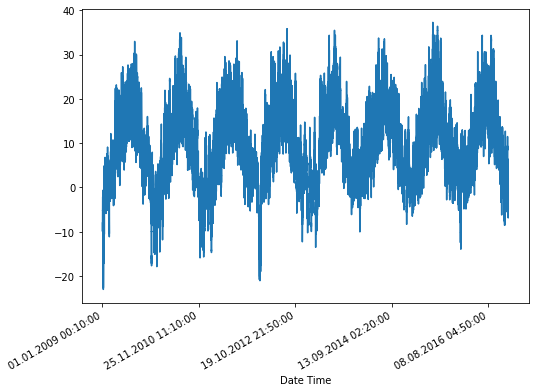

In [11]:
uni_data.plot(subplots=True)

In [12]:
uni_data = uni_data.values

In [13]:
uni_data

array([-8.02, -8.41, -8.51, ..., -3.16, -4.23, -4.82])

In [14]:
uni_train_mean = uni_data[:Train_split].mean()
uni_train_std = uni_data[:Train_split].std()

uni_data = (uni_data - uni_train_mean) / uni_train_std
print(uni_data.shape)

(420551,)


In [15]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data,0,Train_split,univariate_past_history,univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data,Train_split,20000,univariate_past_history,univariate_future_target)

20
10020


In [16]:
x_train_uni[0]

array([[-1.36750532],
       [-1.44348003],
       [-1.46296072],
       [-1.42399933],
       [-1.41620706],
       [-1.37334953],
       [-1.28958255],
       [-1.28958255],
       [-1.34607656],
       [-1.44737617],
       [-1.51166245],
       [-1.53503929],
       [-1.52919508],
       [-1.52529894],
       [-1.49218176],
       [-1.49218176],
       [-1.49997404],
       [-1.5214028 ],
       [-1.52724701],
       [-1.5467277 ]])

In [17]:
def create_time_step(length):
  return list(range(-length,0))

In [18]:
def show_plot(plot_data,delta,title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-','rx','go']
  time_steps = create_time_step(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0
  
  plt.title(title)
  for i,x in enumerate(plot_data):
    if i:
      plt.plot(future,plot_data[i],marker[i],markersize=10, label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i],label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future + 5) * 2])
  plt.xlabel('Time-Step')
  return plt      

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

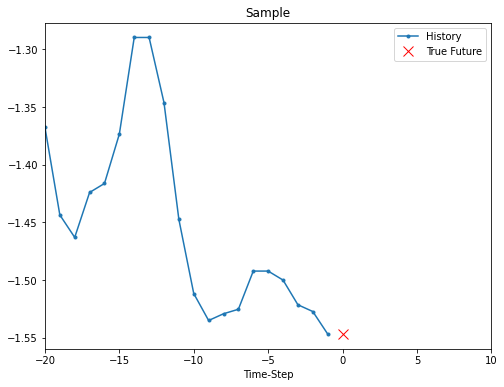

In [19]:
show_plot([x_train_uni[0],y_train_uni[0]], 0, 'Sample')

In [20]:
def baseline(history):
  return np.mean(history)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

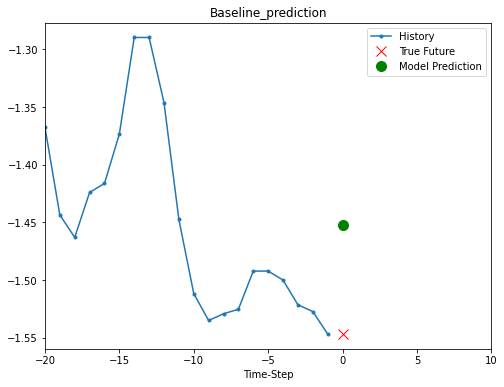

In [21]:
show_plot([x_train_uni[0],y_train_uni[0],baseline(x_train_uni[0])], 0,'Baseline_prediction')

In [22]:
#using RNN

BATCH_SIZE = 256
BUFFER_SIZE = 50000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni,y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni,y_val_uni))
val_univariate = val_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

In [23]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8,input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)                                            
])

simple_lstm_model.compile(optimizer='adam',loss='mse',metrics=['accuracy'])

In [24]:
for x,y in val_univariate.take(1):
  print(simple_lstm_model.predict(x).shape)

(256, 1)


In [25]:
simple_lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 8)                 320       
_________________________________________________________________
dense (Dense)                (None, 1)                 9         
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________


In [26]:
eval_interval = 200
epochs = 20

simple_lstm_model.fit(train_univariate,epochs = epochs,
                      steps_per_epoch = eval_interval,
                      validation_data = val_univariate,validation_steps=50)

Epoch 1/20
200/200 [==============================] - 3s 7ms/step - loss: 0.4366 - accuracy: 0.0000e+00 - val_loss: 1.8917 - val_accuracy: 0.0000e+00
Epoch 2/20
200/200 [==============================] - 1s 5ms/step - loss: 0.0537 - accuracy: 0.0000e+00 - val_loss: 1.3314 - val_accuracy: 0.0000e+00
Epoch 3/20
200/200 [==============================] - 1s 5ms/step - loss: 0.0168 - accuracy: 0.0000e+00 - val_loss: 0.9437 - val_accuracy: 0.0000e+00
Epoch 4/20
200/200 [==============================] - 1s 5ms/step - loss: 0.0080 - accuracy: 0.0000e+00 - val_loss: 0.7254 - val_accuracy: 0.0000e+00
Epoch 5/20
200/200 [==============================] - 1s 5ms/step - loss: 0.0051 - accuracy: 0.0000e+00 - val_loss: 0.5903 - val_accuracy: 0.0000e+00
Epoch 6/20
200/200 [==============================] - 1s 5ms/step - loss: 0.0038 - accuracy: 0.0000e+00 - val_loss: 0.5142 - val_accuracy: 0.0000e+00
Epoch 7/20
200/200 [==============================] - 1s 5ms/step - loss: 0.0032 - accuracy: 0.0000e

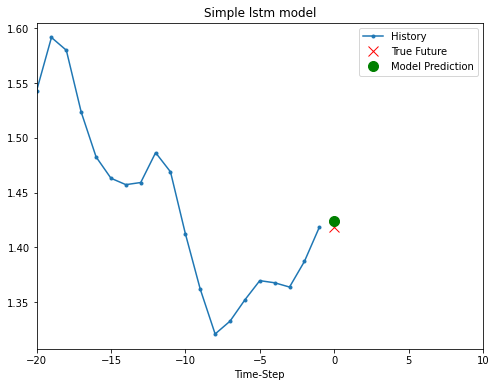

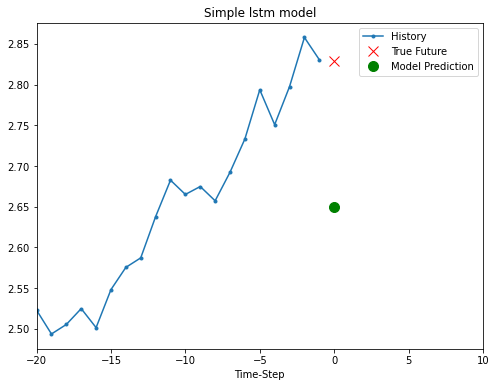

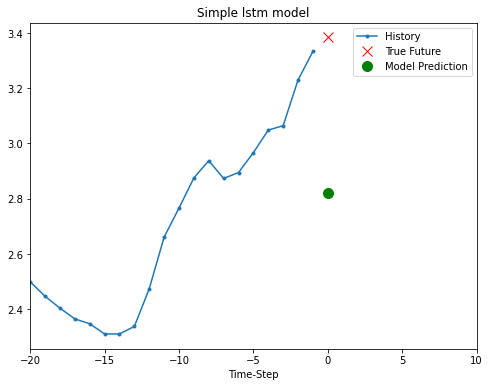

In [27]:
for x,y in val_univariate.take(3):
  plot = show_plot([x[0].numpy(),y[0].numpy(),simple_lstm_model.predict(x)[0]], 0, 'Simple lstm model')
  plt.show()

In [28]:
print = df.columns

feature = ['p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)',
      'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
       'H2OC (mmol/mol)', 'rho (g/m**3)']

features = df[feature]
features.index = df['Date Time']
features.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3)
Date Time,,,,,,,,,,
01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,3.33,3.11,0.22,1.94,3.12,1307.75
01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,3.23,3.02,0.21,1.89,3.03,1309.80
01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,3.21,3.01,0.20,1.88,3.02,1310.24
01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,3.26,3.07,0.19,1.92,3.08,1309.19
01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,3.27,3.08,0.19,1.92,3.09,1309.00


In [29]:
dataset = features.values
data_mean = dataset.mean()
data_std = dataset.std()
dataset = (dataset- data_mean) / data_std

In [30]:
def multivariate_data(dataset,target,start_index,end_index,history_size, target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size
  
  for i in range(start_index, end_index):
    indices = range(i - history_size, i,step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])
  return np.array(data), np.array(labels)    

In [31]:
past_history = 720
future_target = 72
step = 6
Train_split = 50000
x_train_single, y_train_single = multivariate_data(dataset,dataset[:,1],0,Train_split,past_history,future_target, step, single_step=True)
x_val_single, y_val_single = multivariate_data(dataset,dataset[:,1],Train_split,100000,past_history,future_target, step, single_step=True)

In [32]:
x_train_single.shape[-2:]

(120, 10)

In [33]:
x_val_single.shape

(49280, 120, 10)

In [34]:
BATCH_SIZE = 128
BUFFER_SIZE = 1000
train_single = tf.data.Dataset.from_tensor_slices((x_train_single,y_train_single))
train_single = train_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_single = tf.data.Dataset.from_tensor_slices((x_val_single,y_val_single))
val_single = val_single.cache().batch(BATCH_SIZE).repeat()

In [35]:
simple_step_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32,input_shape=(120,10),return_sequences = True),
    tf.keras.layers.LSTM(32, return_sequences = True),
    tf.keras.layers.LSTM(32, return_sequences = False),
    tf.keras.layers.Dense(1)                                            
])

simple_step_model.compile(optimizer='adam',loss='mse',metrics=['accuracy'])

In [36]:
simple_step_history = simple_step_model.fit(train_single,epochs=10,
                                            steps_per_epoch = 200,
                                            validation_data = val_single,validation_steps=50)

Epoch 1/10
200/200 [==============================] - 8s 24ms/step - loss: 0.0123 - accuracy: 0.0000e+00 - val_loss: 0.0025 - val_accuracy: 0.0000e+00
Epoch 2/10
200/200 [==============================] - 4s 21ms/step - loss: 1.0421e-04 - accuracy: 0.0000e+00 - val_loss: 2.6396e-04 - val_accuracy: 0.0000e+00
Epoch 3/10
200/200 [==============================] - 4s 19ms/step - loss: 8.3819e-05 - accuracy: 0.0000e+00 - val_loss: 0.0014 - val_accuracy: 0.0000e+00
Epoch 4/10
200/200 [==============================] - 4s 19ms/step - loss: 1.0075e-04 - accuracy: 0.0000e+00 - val_loss: 2.3333e-04 - val_accuracy: 0.0000e+00
Epoch 5/10
200/200 [==============================] - 4s 19ms/step - loss: 7.0244e-05 - accuracy: 0.0000e+00 - val_loss: 0.0011 - val_accuracy: 0.0000e+00
Epoch 6/10
200/200 [==============================] - 4s 19ms/step - loss: 9.3599e-05 - accuracy: 0.0000e+00 - val_loss: 8.2769e-05 - val_accuracy: 0.0000e+00
Epoch 7/10
200/200 [==============================] - 4s 19ms/

In [37]:
def plot_train_history(history,title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs,loss,'b',label='Training_loss')
  plt.plot(epochs,val_loss,'r',label='validation_loss')
  plt.title(title)
  plt.legend()

  plt.show()

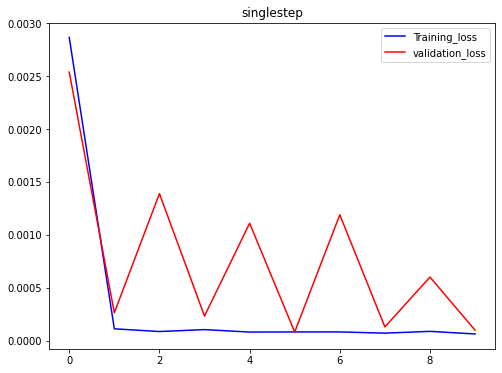

In [38]:
plot_train_history(simple_step_history,'singlestep')

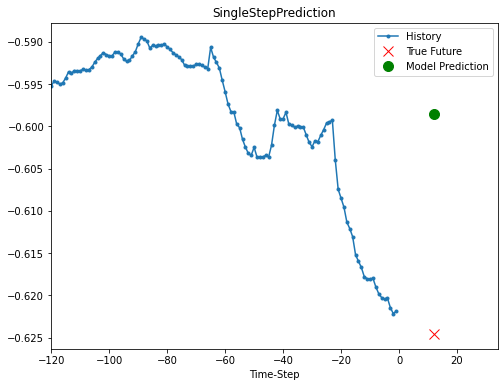

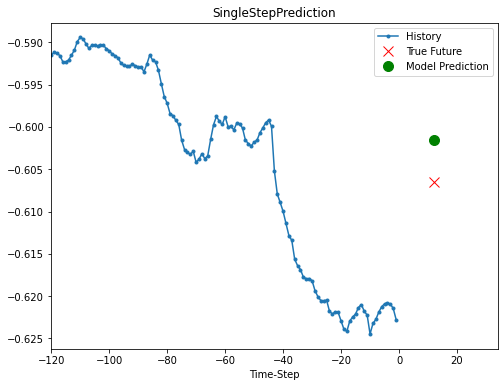

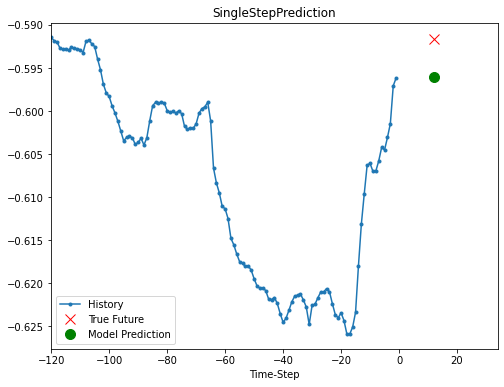

In [39]:
for x,y in val_single.take(3):
  plot = show_plot([x[0][:,1].numpy(), y[0].numpy(),simple_step_model.predict(x)[0]], 12,'SingleStepPrediction')
  plot.show()

In [40]:
x_train_multi, y_train_multi = multivariate_data(dataset,dataset[:,1],0,Train_split,past_history,future_target, 6)
x_val_multi, y_val_multi = multivariate_data(dataset,dataset[:,1],Train_split,100000,past_history,future_target, 6)

In [60]:
train_multi = tf.data.Dataset.from_tensor_slices((x_train_multi,y_train_multi))
train_multi = train_multi.cache().shuffle(BUFFER_SIZE).batch(256).repeat()

val_multi = tf.data.Dataset.from_tensor_slices((x_val_multi,y_val_multi))
val_multi = val_multi.cache().batch(256).repeat()

In [89]:
x_train_multi[0].shape

(120, 10)

In [44]:
def multi_step(history, true_future, prediction):
  plt.figure(figsize=(12,6))
  num_in = create_time_step(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:,1]),label='History')
  plt.plot(np.arange(num_out)/step,np.array(true_future),'bo',label='True')

  if prediction.any():
    plt.plot(np.arange(num_out)/step,np.array(prediction),'ro',label='rue')
  plt.legend(loc='upper left')
  plt.show()

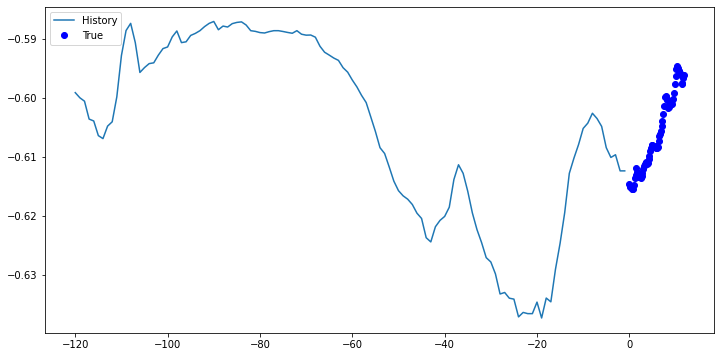

In [45]:
for x, y in train_multi.take(1):
  multi_step(x[0],y[0],np.array([0]))

In [92]:
multi_step_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32,input_shape=(120,10),return_sequences = True),
    tf.keras.layers.LSTM(16,activation='relu',return_sequences = True),
    tf.keras.layers.LSTM(32,return_sequences = False),
    tf.keras.layers.Dense(72)                                            
])

multi_step_model.compile(optimizer='adam',loss='mse',metrics=['mean_squared_error'])

In [ ]:
his = multi_step_model.fit(train_multi,epochs=10,steps_per_epoch=200,validation_data=val_multi,validation_steps=50)

Epoch 1/10
109/200 [===============>..............] - ETA: 16s - loss: 0.1437 - mean_squared_error: 0.1437

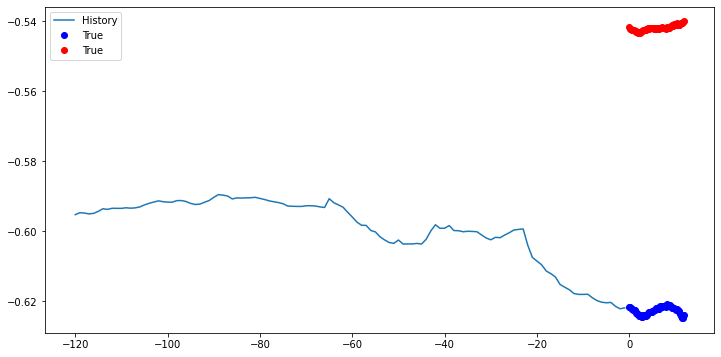

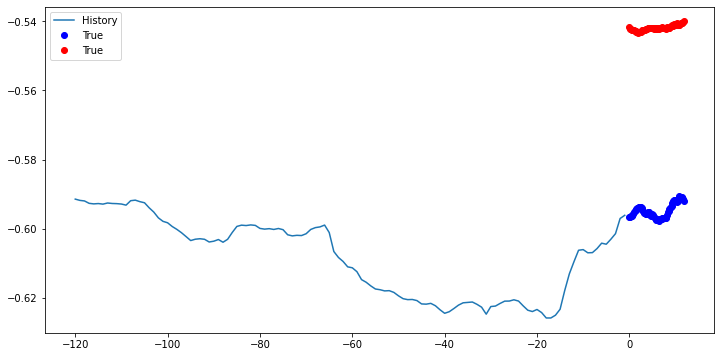

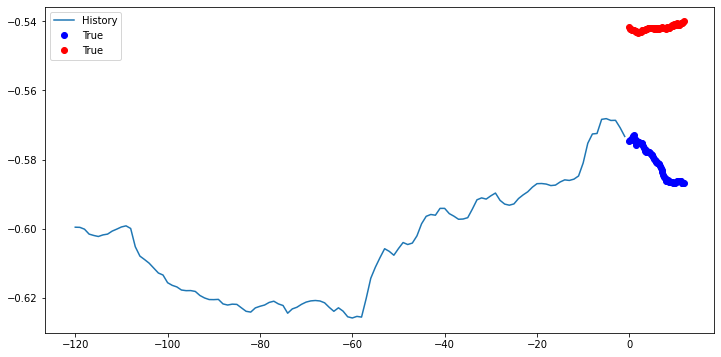

In [86]:
for x,y in val_multi.take(3):
  multi_step(x[0],y[0],multi_step_model.predict(x)[0])